Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](img/descargar.png)

In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=10,repr.plot.width=10,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
airbnb<-airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
df_madrid<-subset(airbnb[airbnb$City=='Madrid' & airbnb$Room.Type=='Entire home/apt' & airbnb$Neighbourhood!='',], select=-c(Room.Type,City))

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [4]:
#Primero me creo una variable para tener los metros cuadrados
df_madrid$Square.Meters<-df_madrid$Square.Feet*0.092903

In [5]:
sum(is.na(df_madrid$Square.Meters))/nrow(df_madrid)*100

[1] 93.80468

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [6]:
sum(na.omit(df_madrid$Square.Meters==0))/length(na.omit(df_madrid$Square.Meters))*100

[1] 36.88761

Reemplazar todos los 0m^2 por NA 

In [7]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

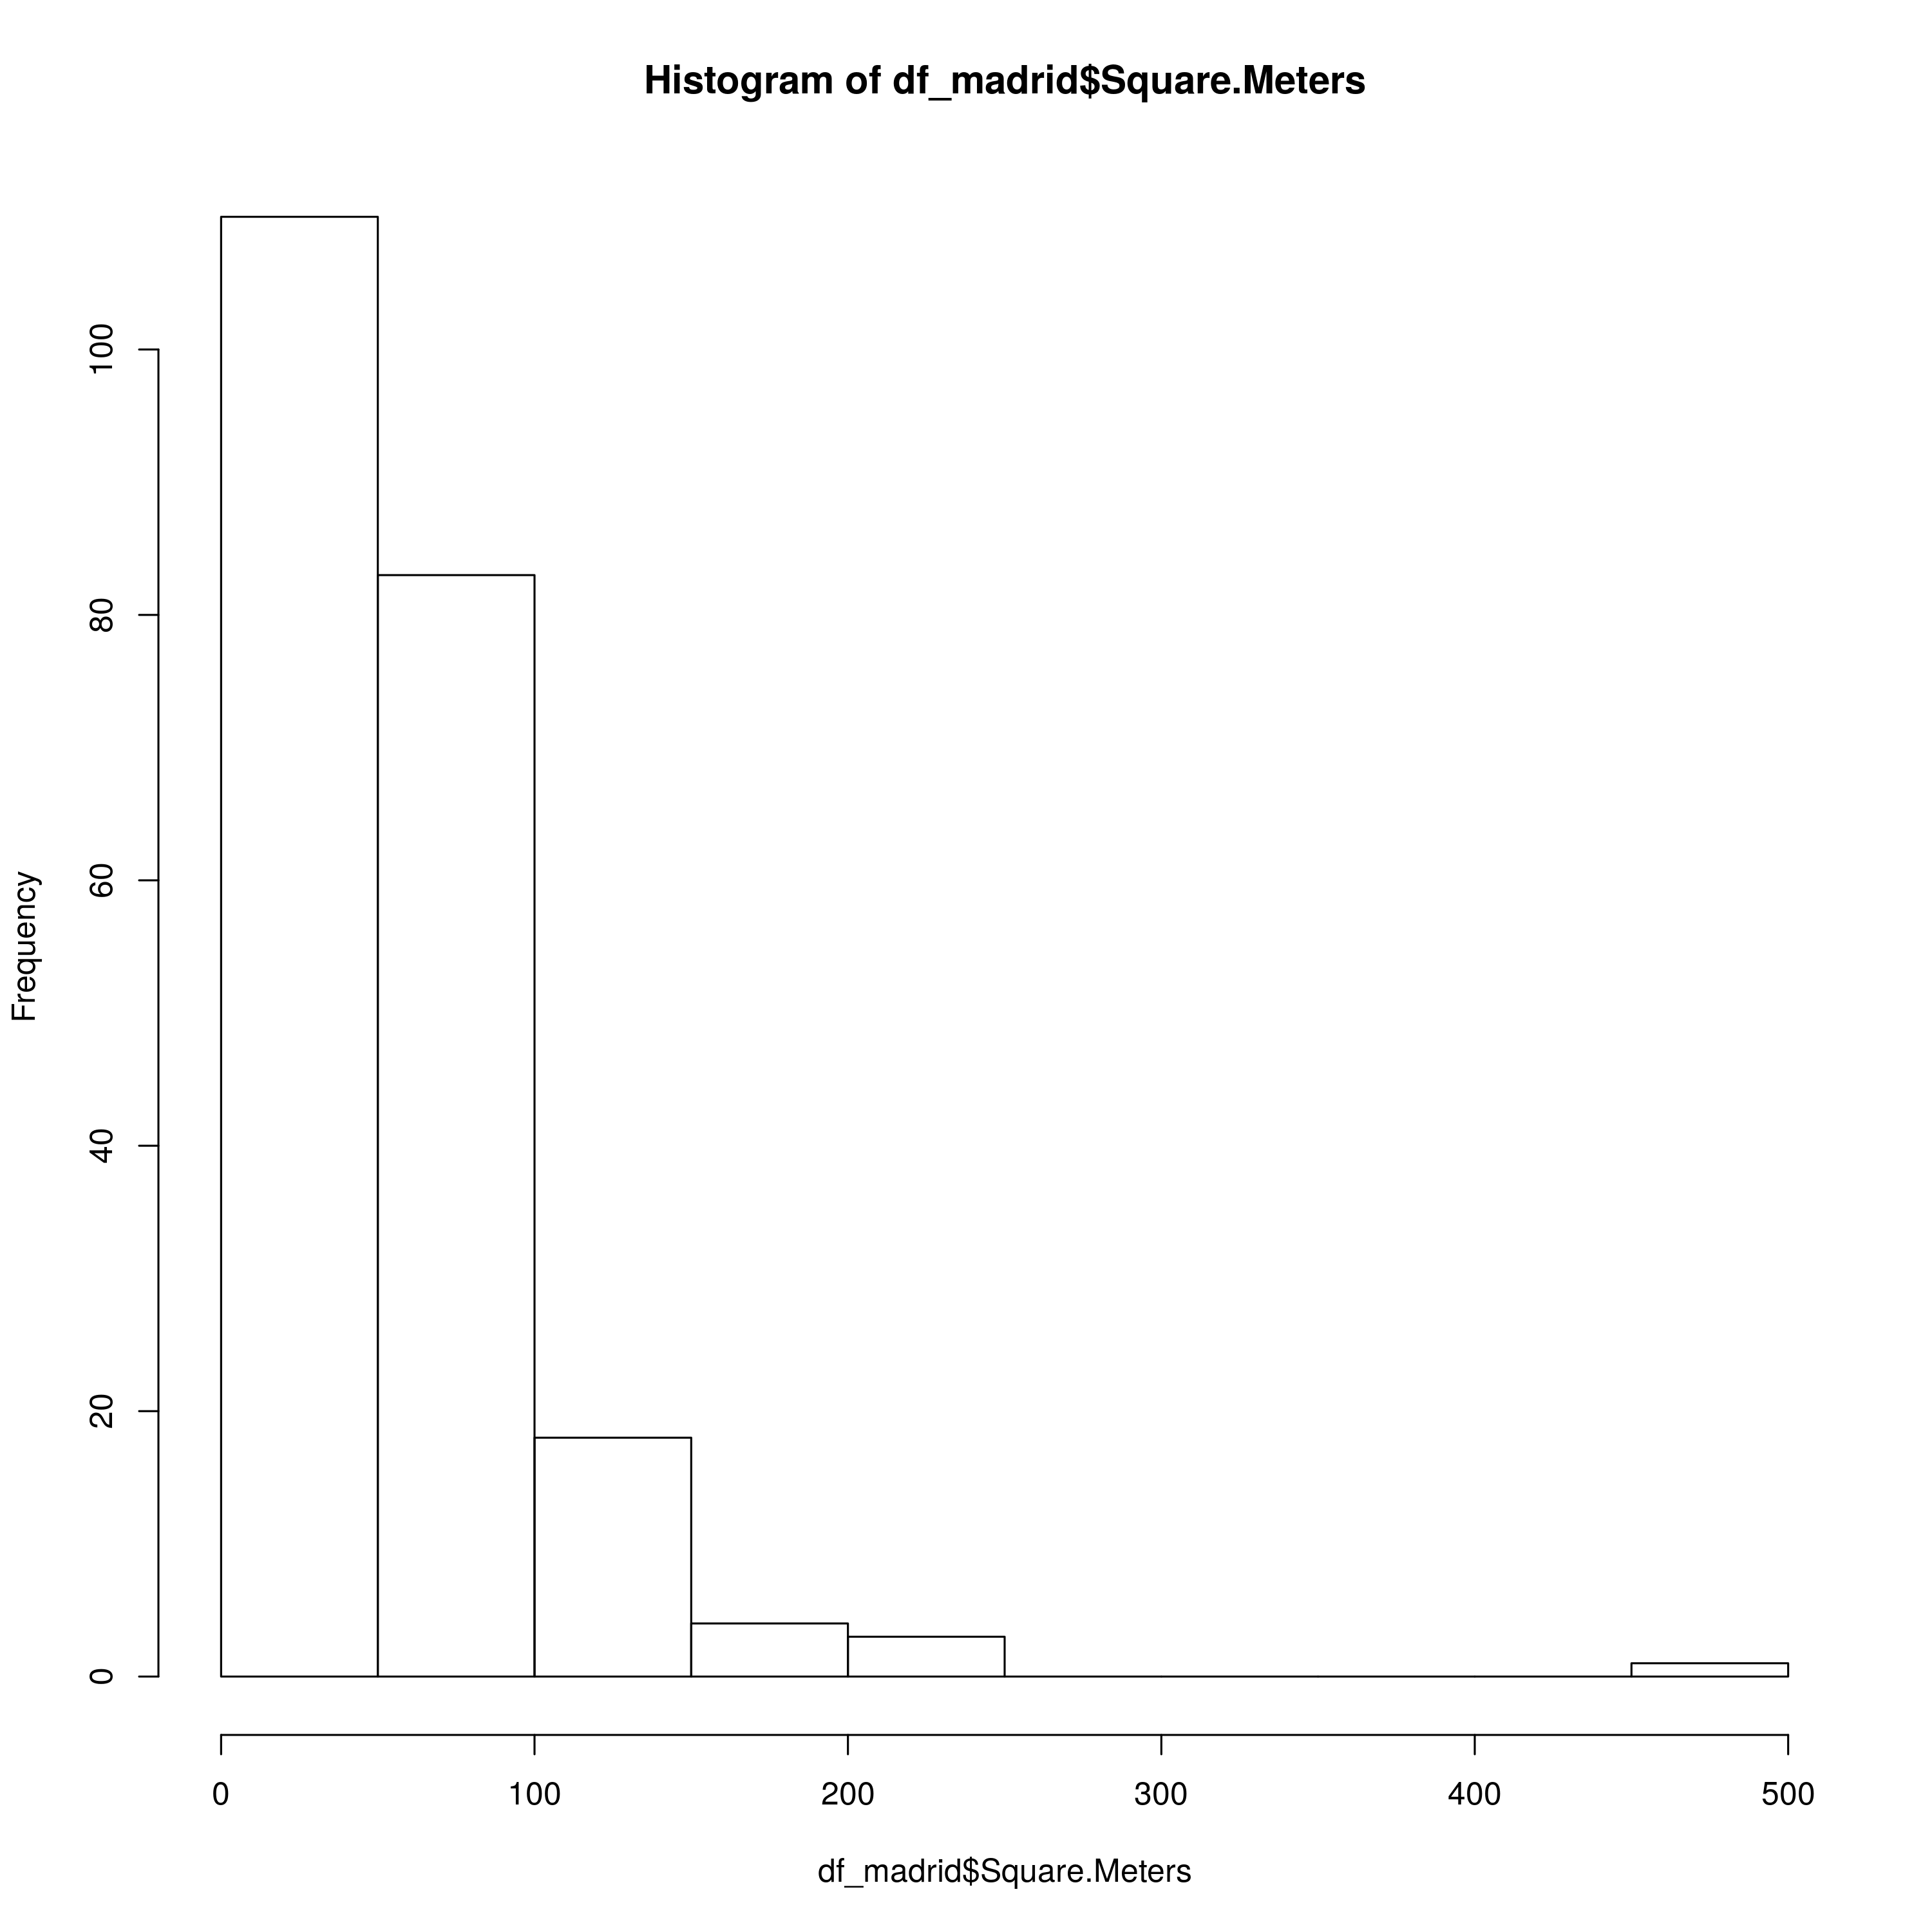

In [8]:
hist(df_madrid$Square.Meters)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
2368,Jerónimos,16,5,5,13,365,5167,5,37,98,40.41826,-3.690208,480.0298


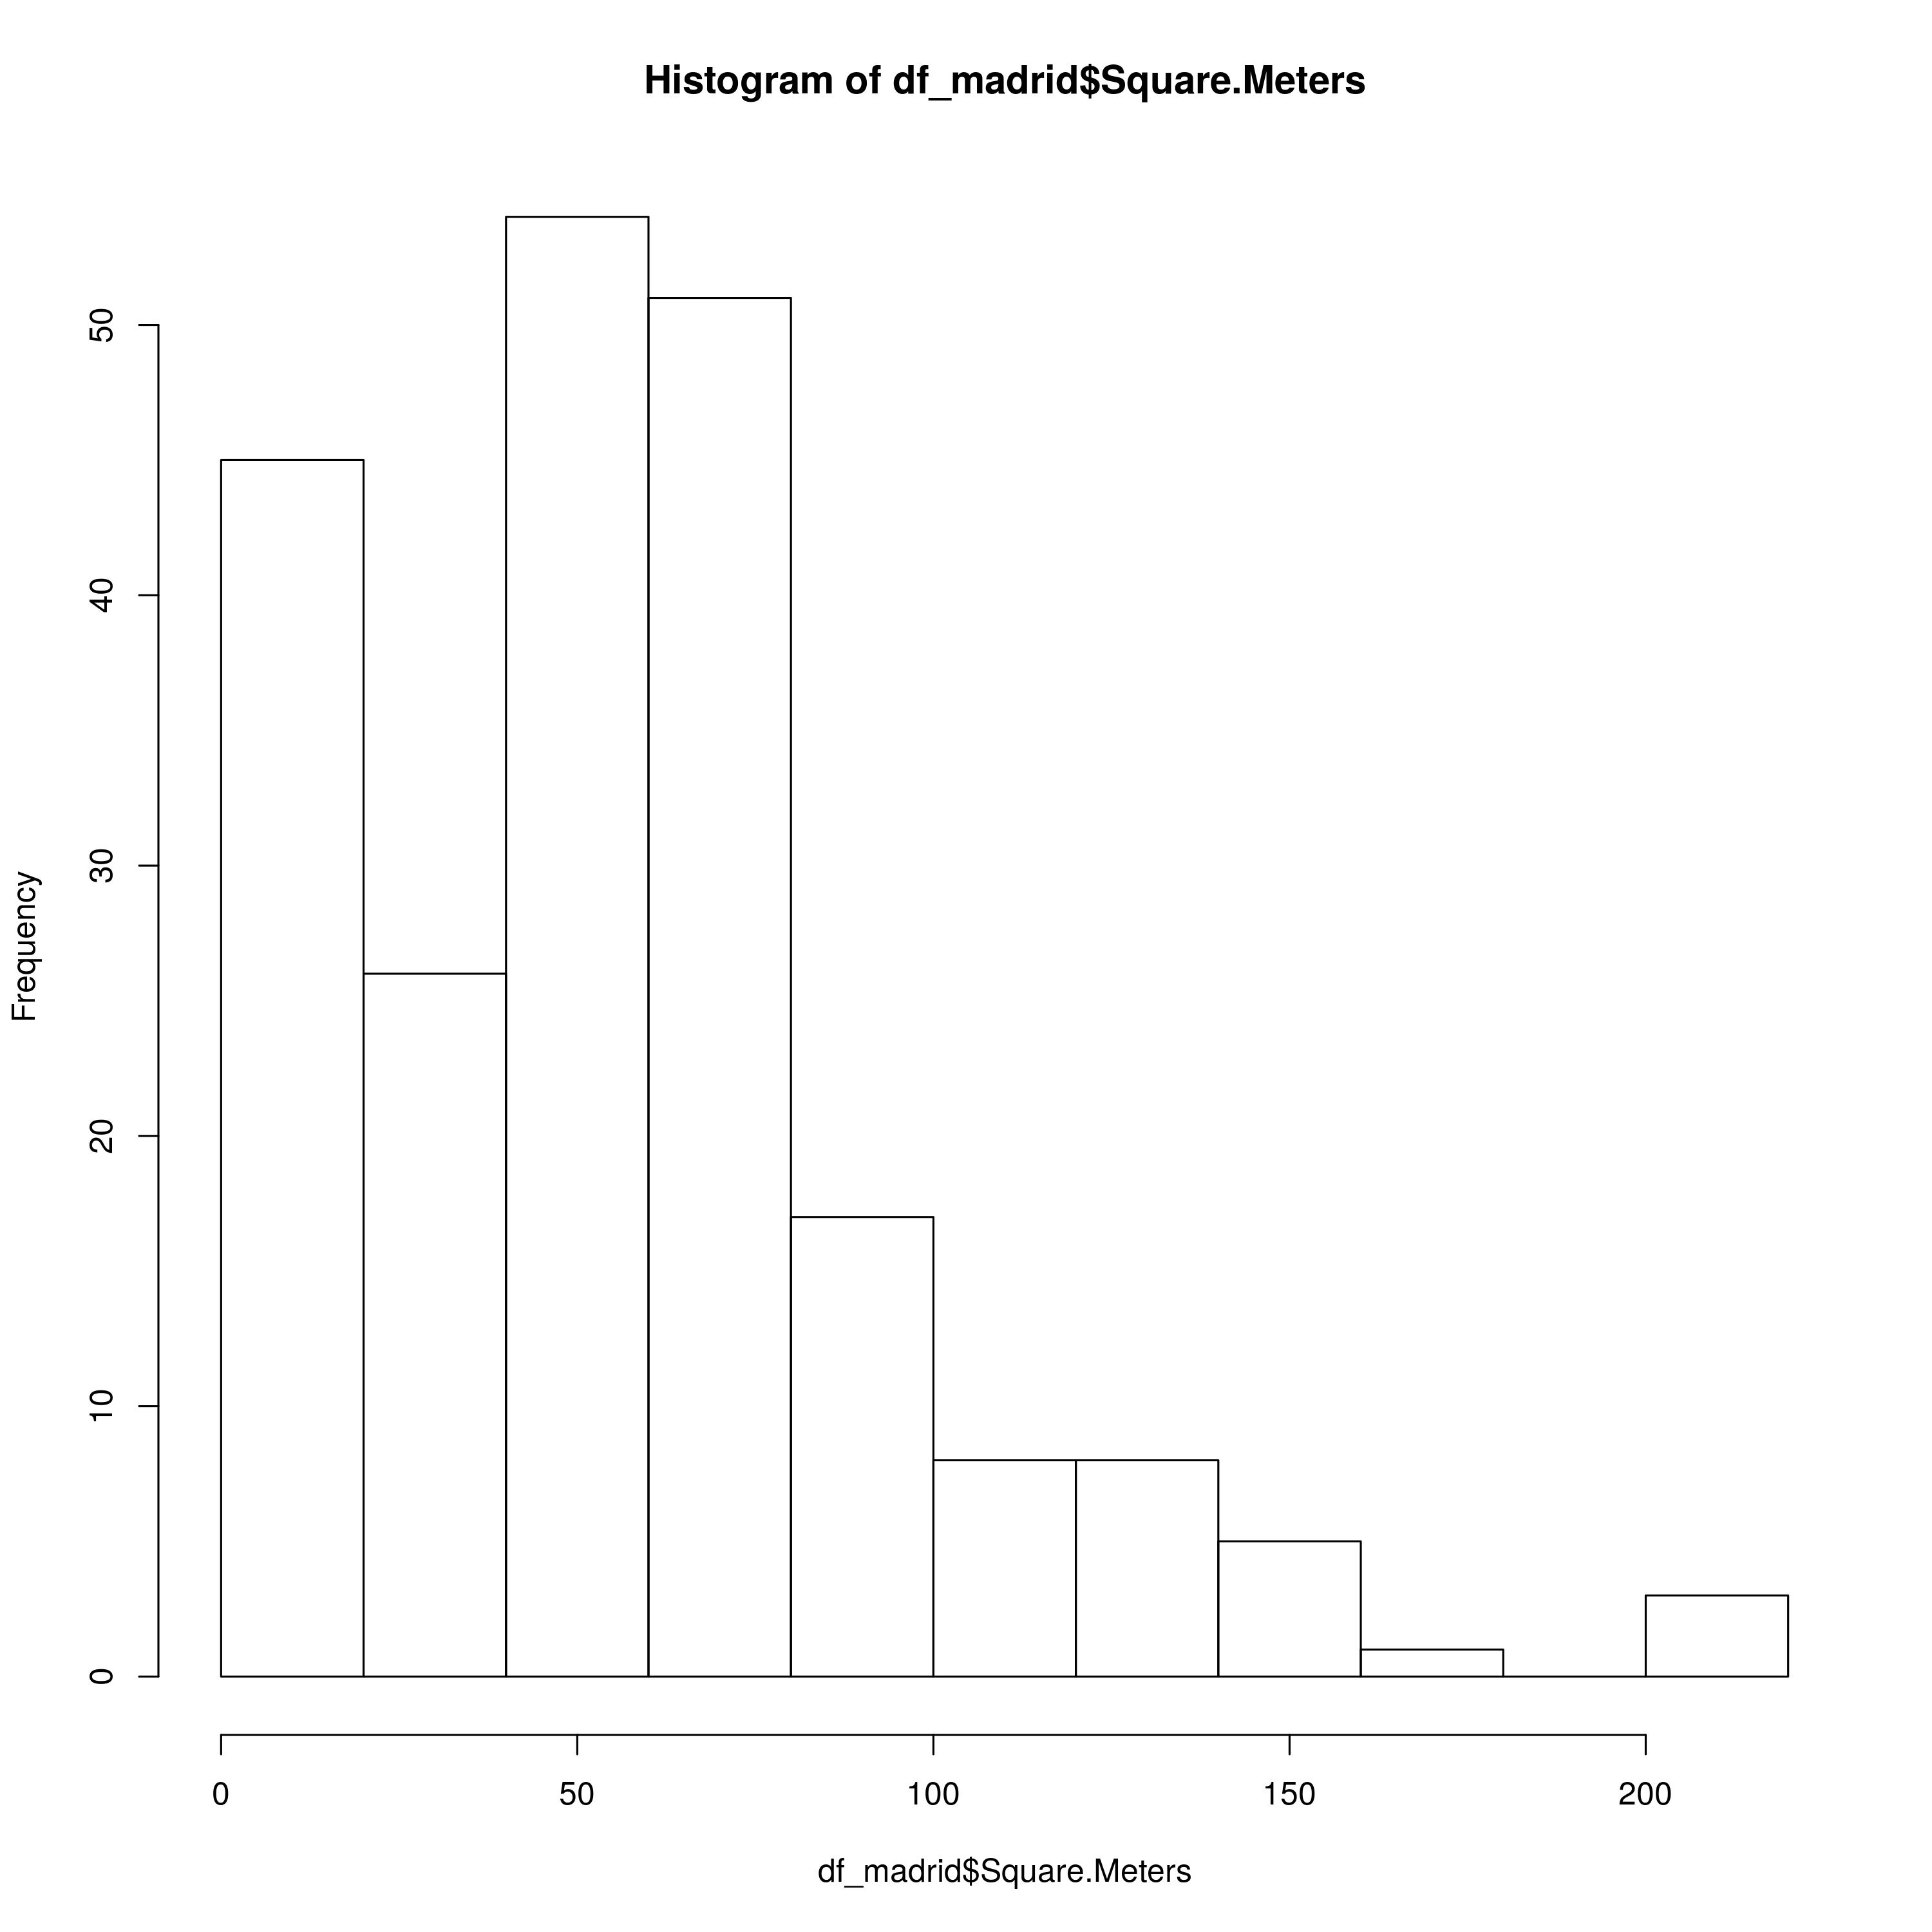

In [9]:
# Tenemos un valor que supera los 450 y puede considerarse un outlayer
na.omit(df_madrid[df_madrid$Square.Meters>450,])

# Al tratarse de un único caso aislado que supera por más del doble al siguiente apartamento más grande, optaré por eliminarlo del dataframe
df_madrid <- df_madrid[-which(df_madrid$Square.Meters>450),]

hist(df_madrid$Square.Meters)

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20] <- NA

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message in resm[lower.tri(resm)] <- round(tky.result$p.adj, 4):
“number of items to replace is not a multiple of replacement length”


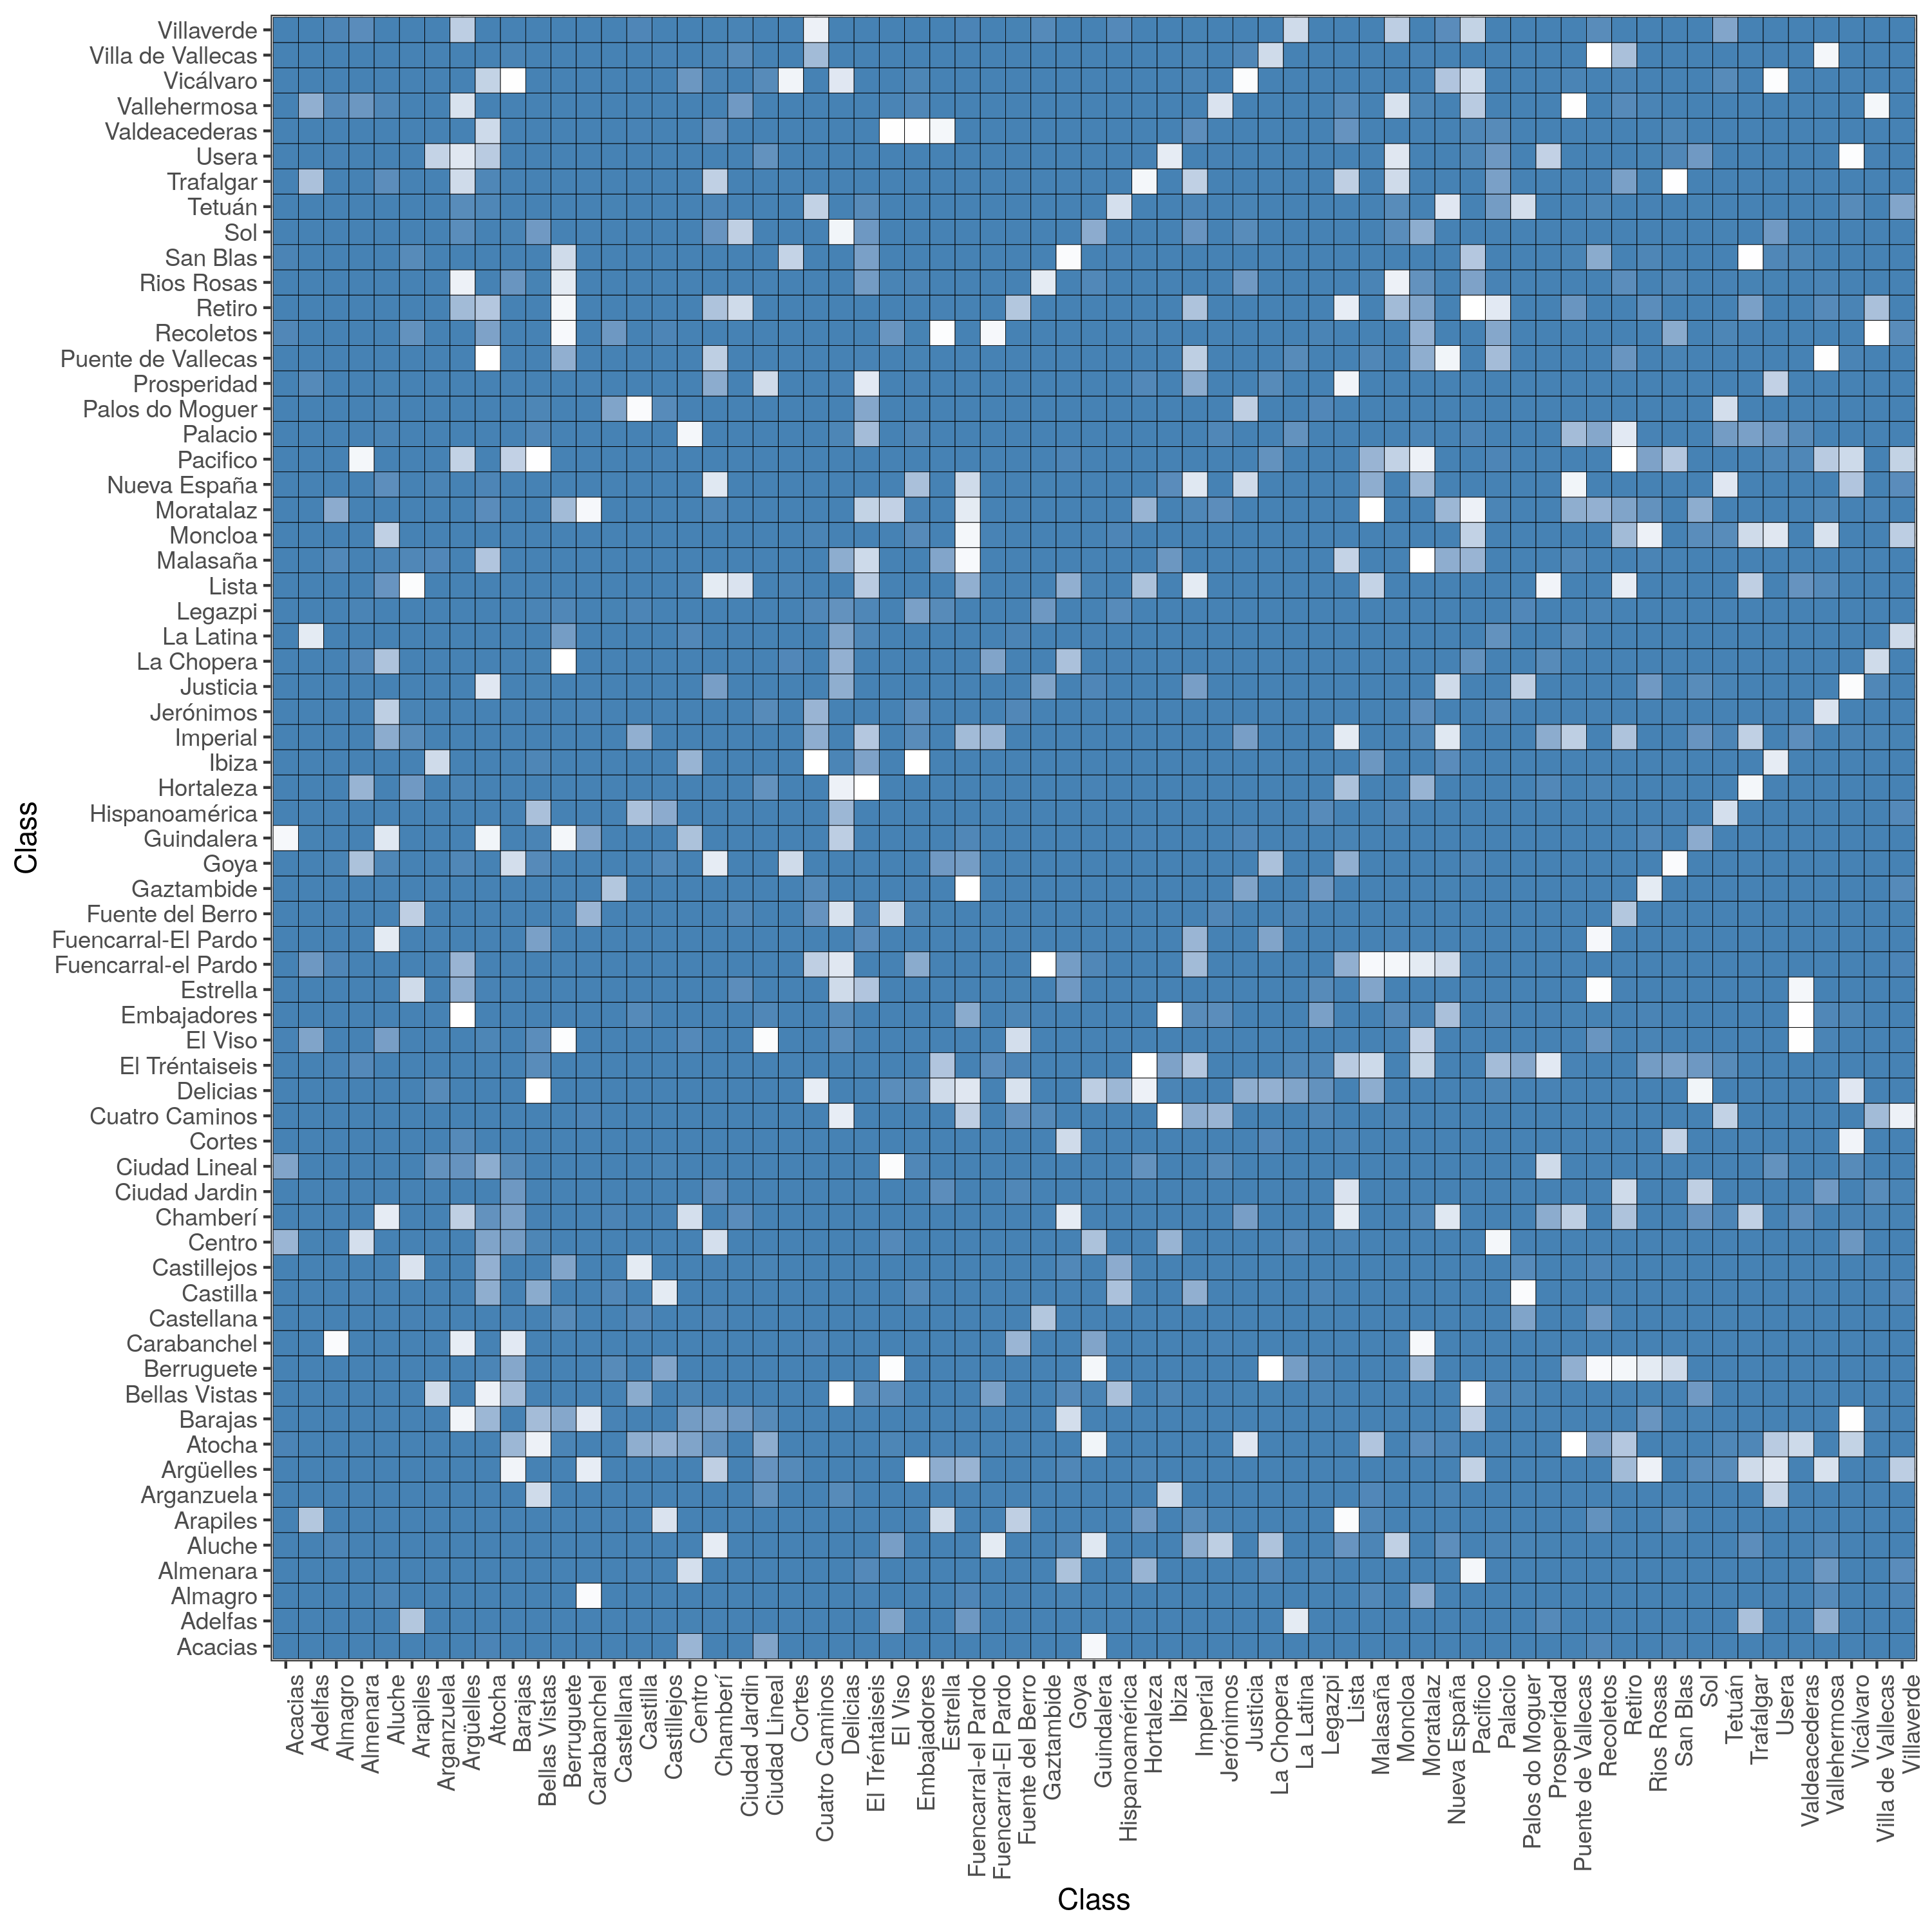

In [11]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [12]:
hc <- hclust(dist(1-resm))
hcd <-as.dendrogram(hc)

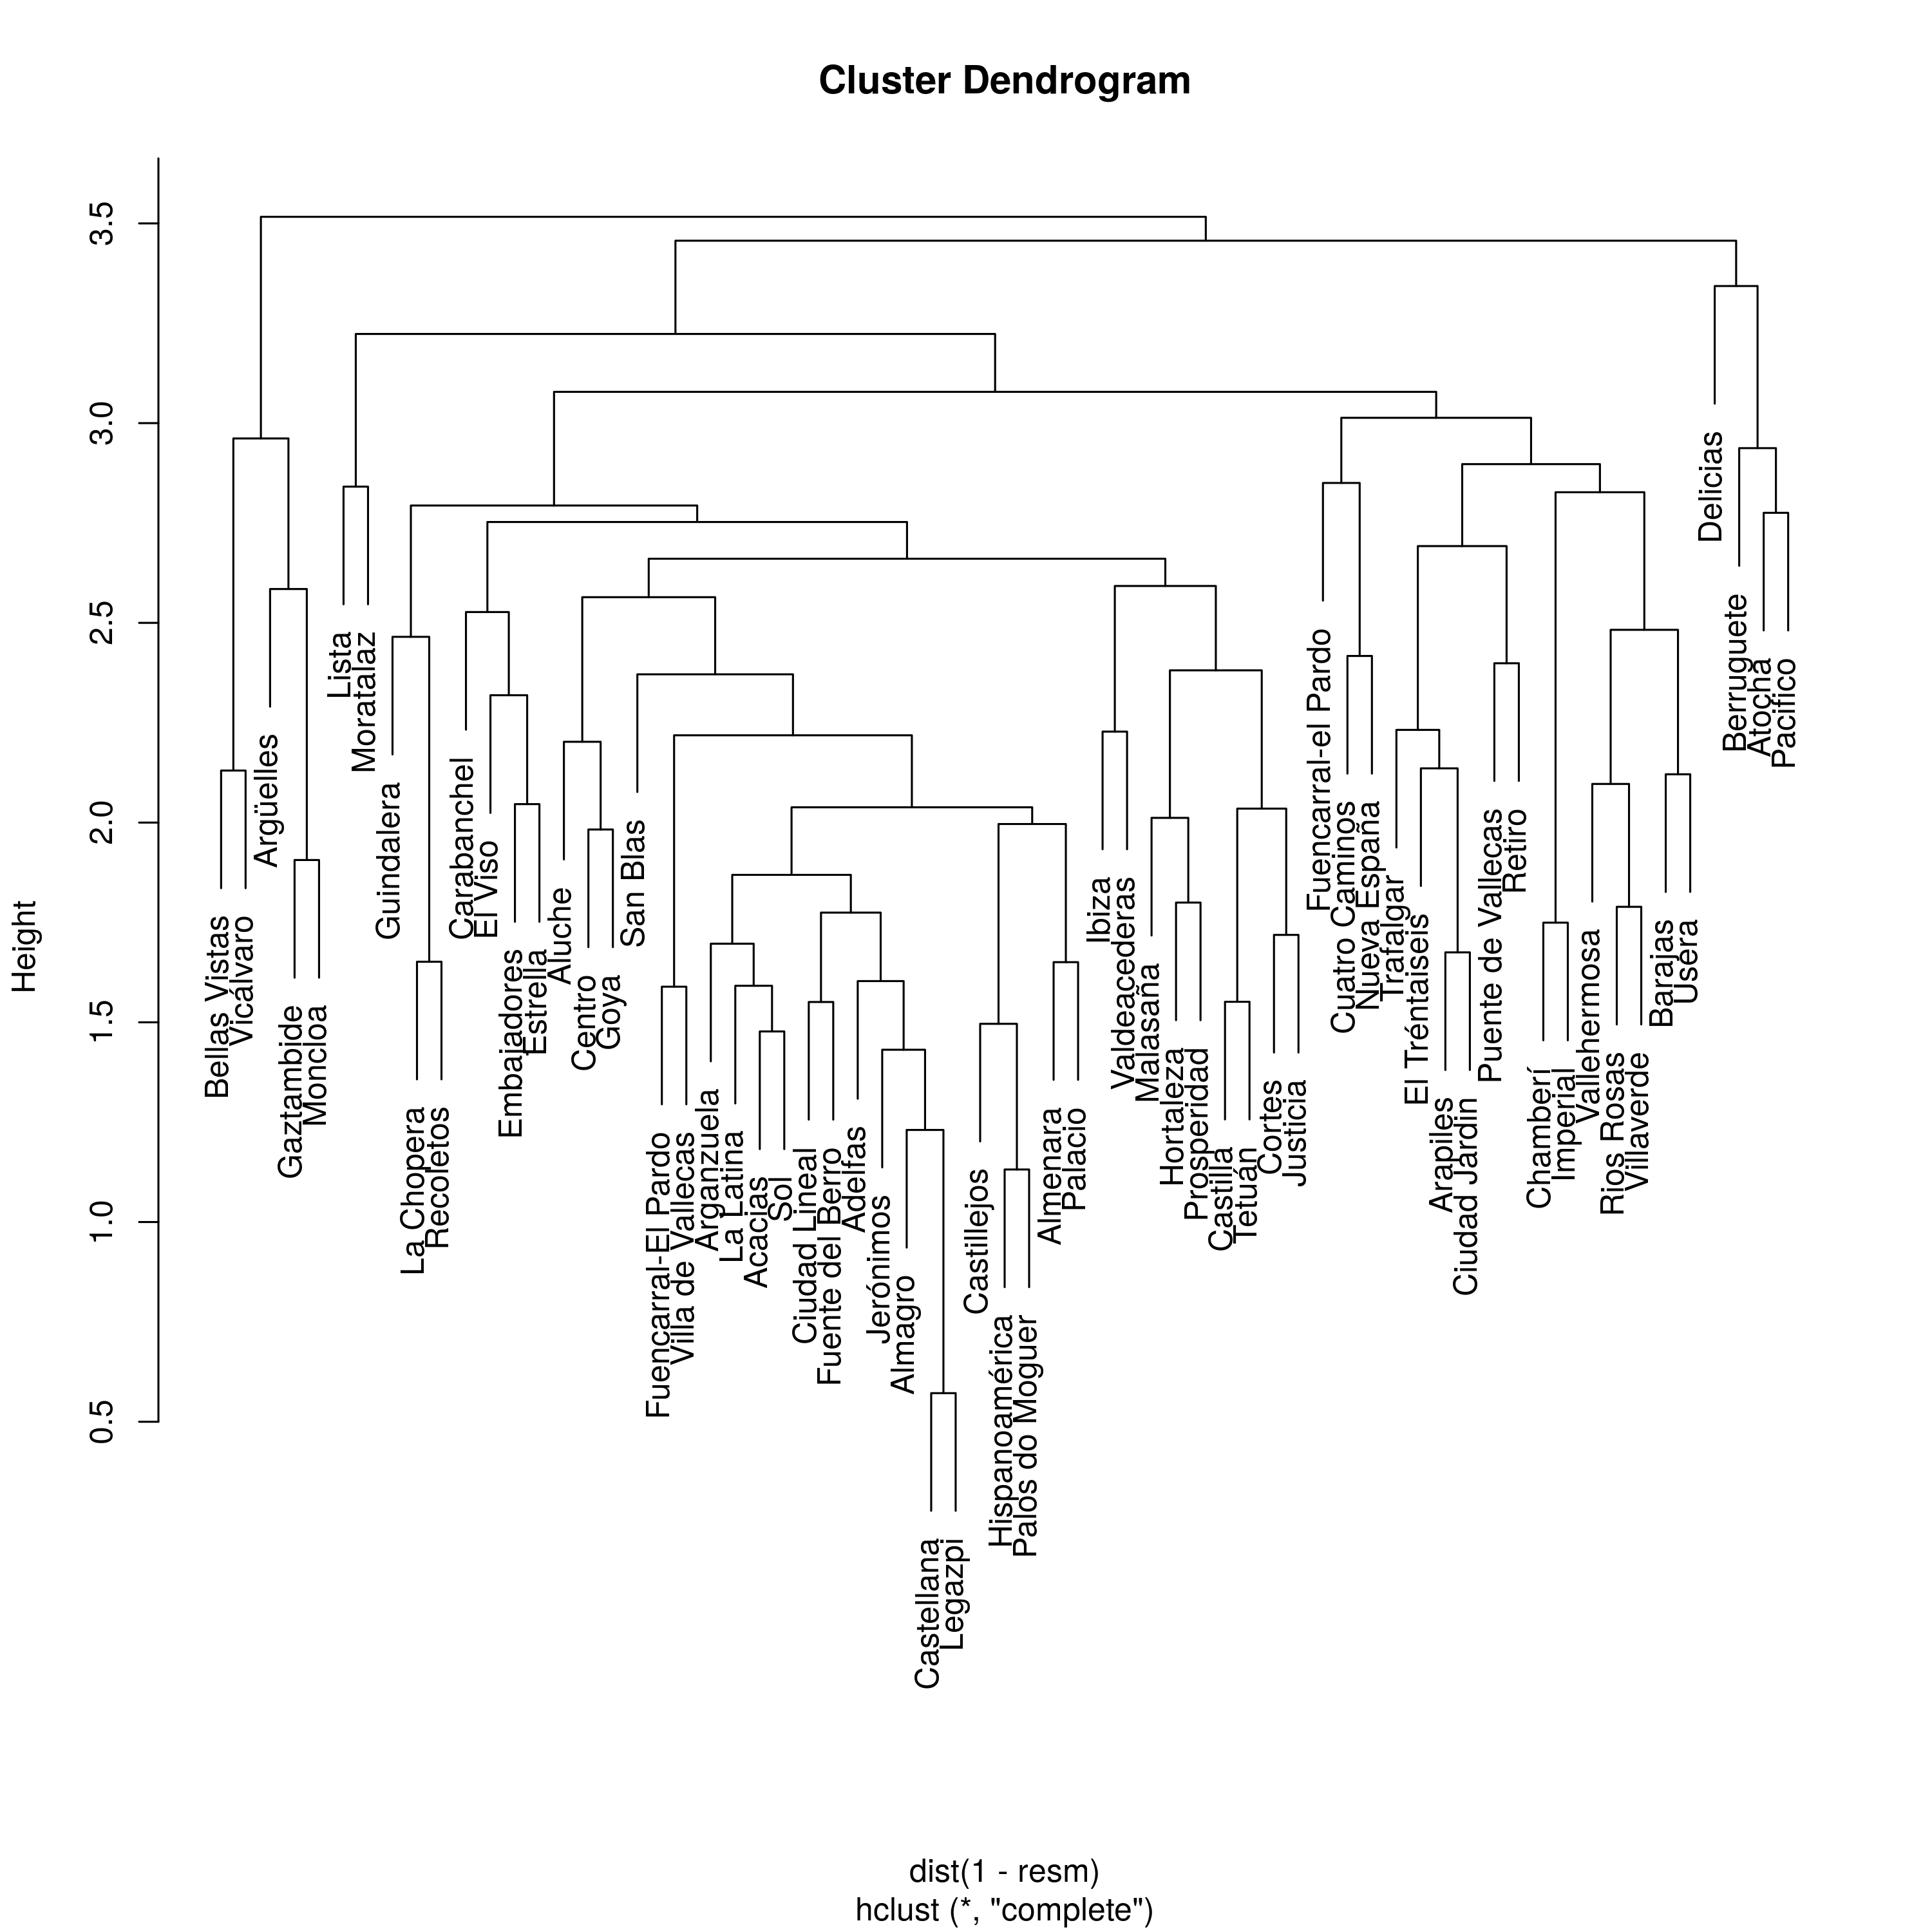

In [13]:
plot(hc)

Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

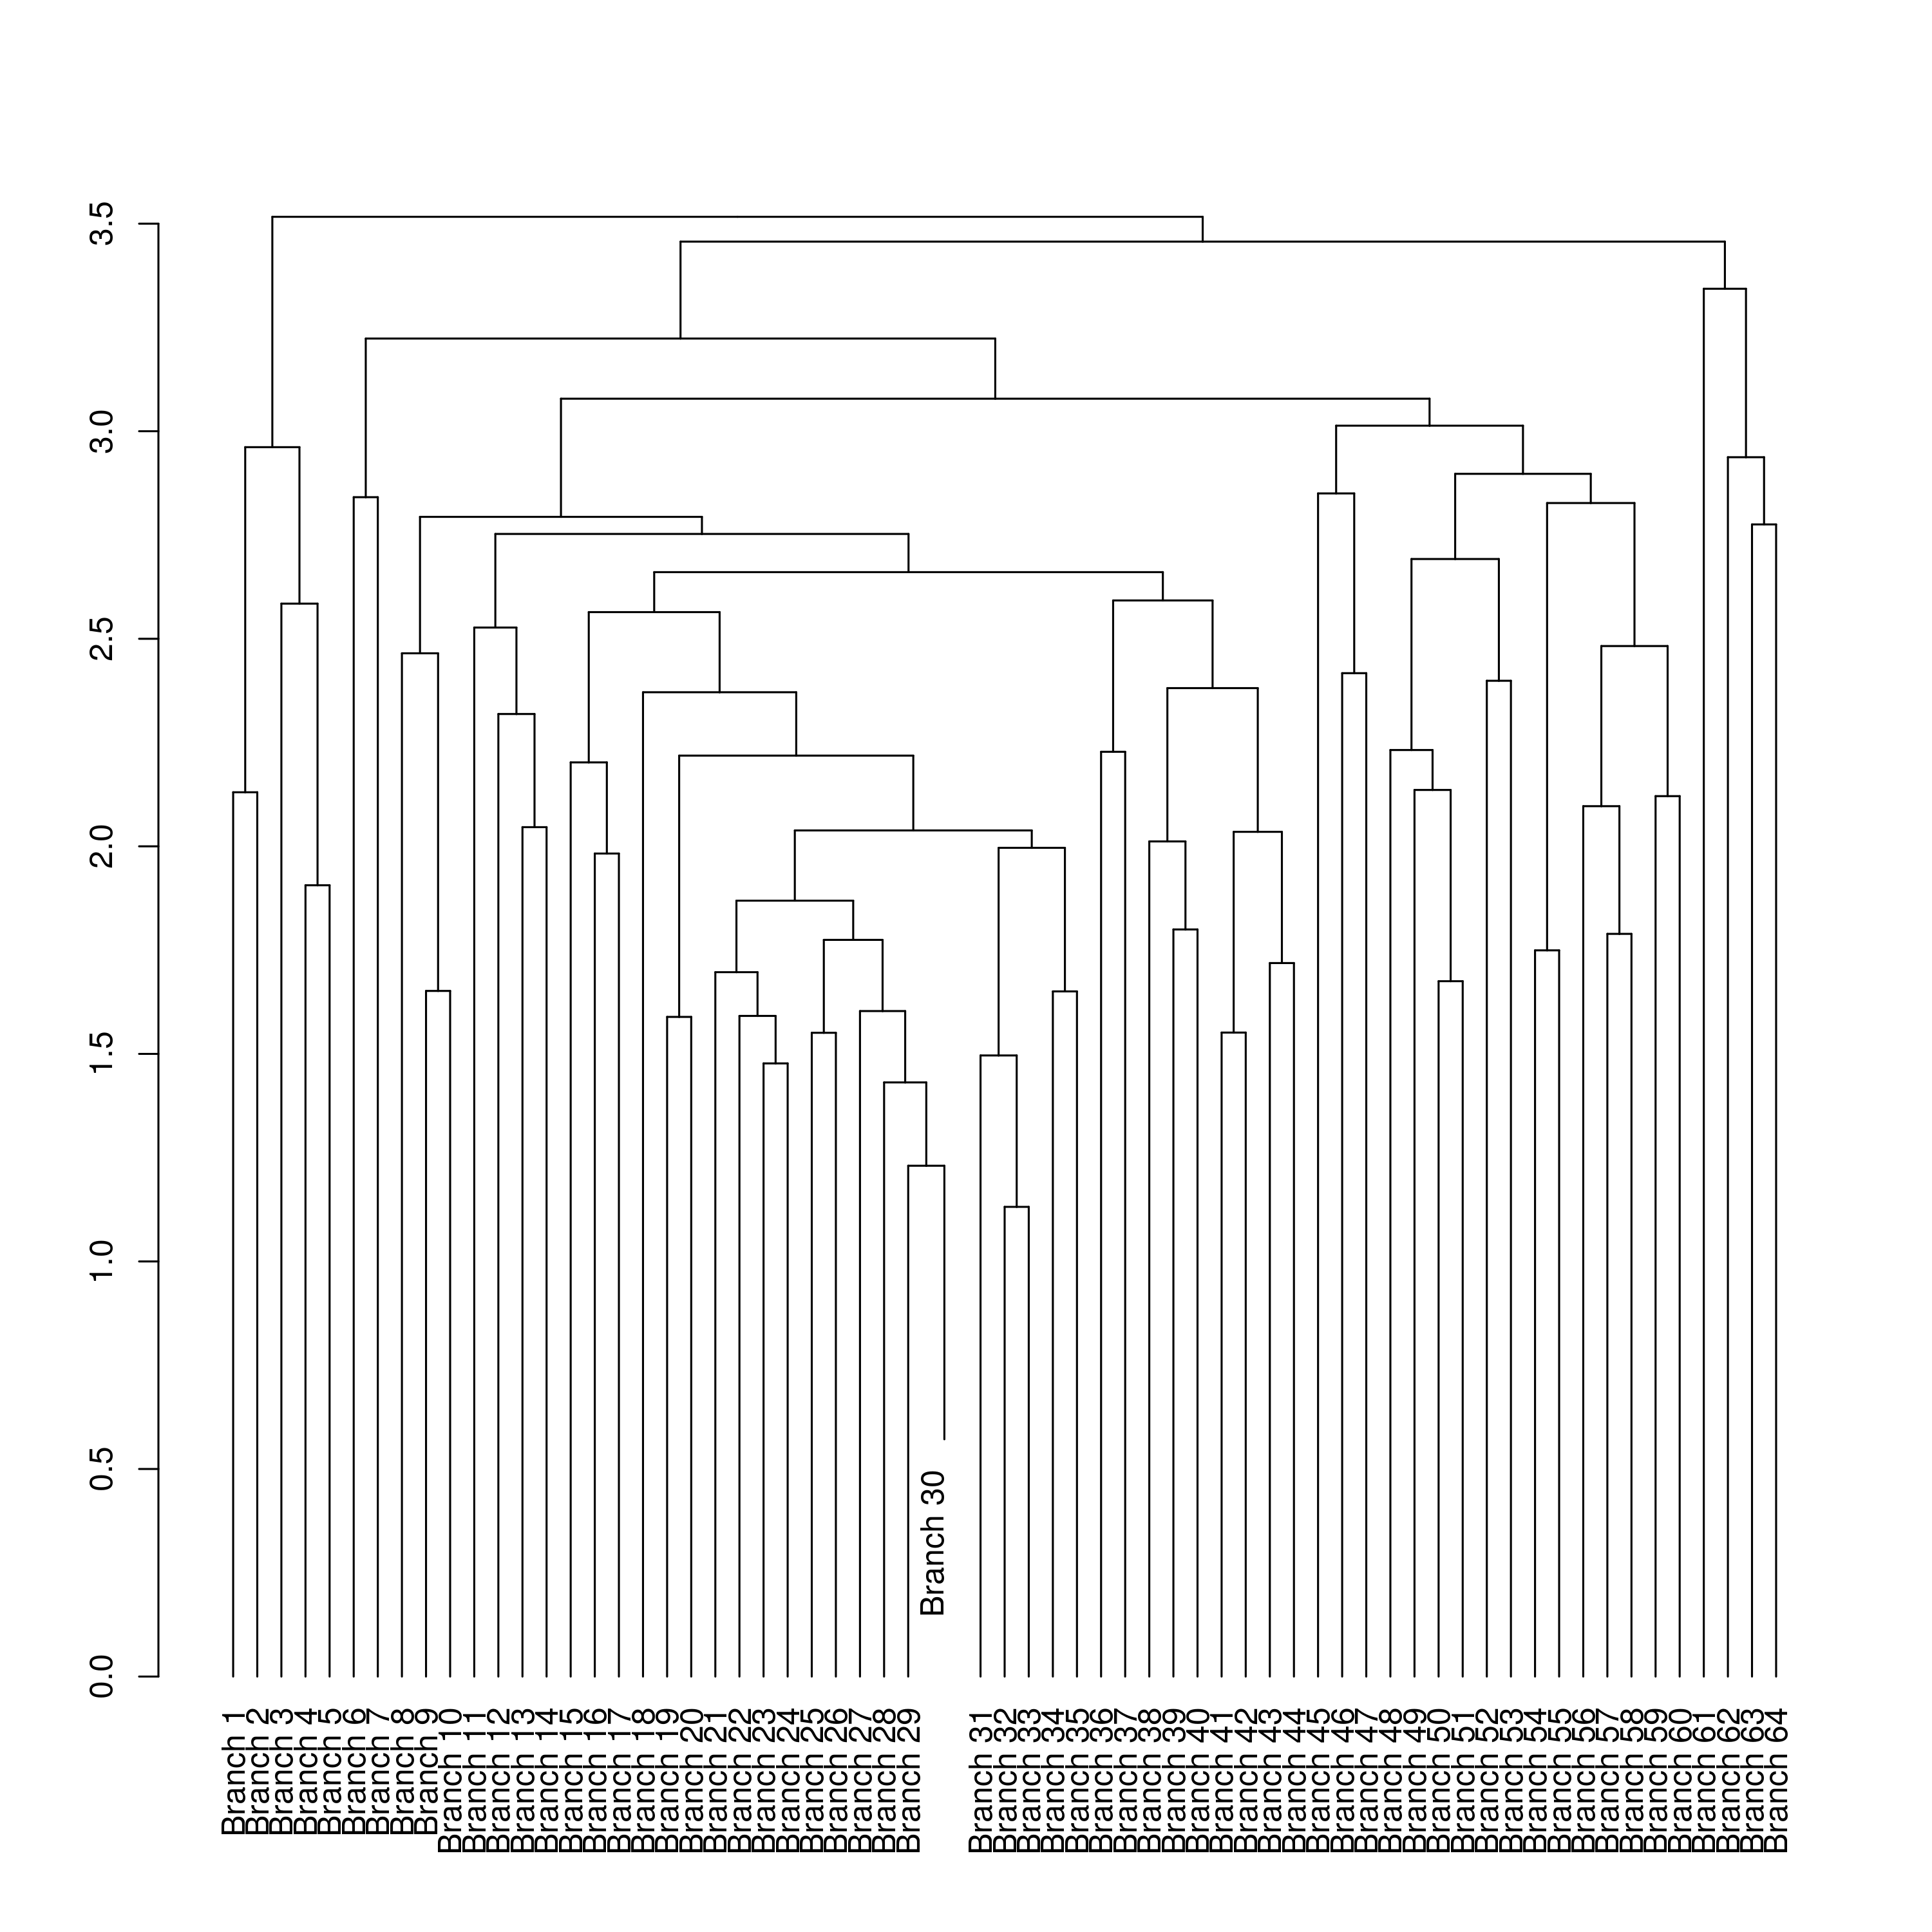

In [14]:
plot(cut(hcd, h=0.9)$upper)

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [15]:
clusters <- as.data.frame(cutree(hc,h=0.9))
colnames(clusters) <- 'neighb_id'
clusters$Neighbourhood <- rownames(clusters)

In [16]:
df_madrid <- merge(df_madrid, clusters)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [17]:
colnames(df_madrid)

[1] "Neighbourhood"        "Accommodates"         "Bathrooms"           
 [4] "Bedrooms"             "Beds"                 "Price"               
 [7] "Square.Feet"          "Guests.Included"      "Extra.People"        
[10] "Review.Scores.Rating" "Latitude"             "Longitude"           
[13] "Square.Meters"        "neighb_id"

In [101]:
# Para estos grupos usaré un dataframe que no tenga valores NA
complete_df_madrid <- df_madrid[complete.cases(df_madrid$Square.Meters),]

idx <- sample(1:nrow(complete_df_madrid),nrow(complete_df_madrid)*0.7)
df_madrid.train <- complete_df_madrid[idx,]
df_madrid.test <- complete_df_madrid[-idx,]

In [102]:
model_df_madrid <- glm(Square.Meters~Bathrooms+Bedrooms+Accommodates+Price,data=df_madrid.train)
summary(model_df_madrid)


Call:
glm(formula = Square.Meters ~ Bathrooms + Bedrooms + Accommodates + 
    Price, data = df_madrid.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-51.589  -11.239   -1.166    8.268   84.937  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.62086    5.21632   0.119 0.905471    
Bathrooms    24.98676    4.69501   5.322 5.33e-07 ***
Bedrooms     11.58815    2.97593   3.894 0.000168 ***
Accommodates  2.37360    1.35114   1.757 0.081696 .  
Price         0.07780    0.03129   2.487 0.014366 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 344.5305)

    Null deviance: 133142  on 116  degrees of freedom
Residual deviance:  38587  on 112  degrees of freedom
  (4 observations deleted due to missingness)
AIC: 1022.5

Number of Fisher Scoring iterations: 2


In [103]:
df_madrid.test$Estimated.SqMet <- predict(model_df_madrid, df_madrid.test)

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

In [104]:
df_madrid.test$error <- NA
df_madrid.test$error <- sqrt((as.numeric(df_madrid.test$Square.Meters)-as.numeric(df_madrid.test$Estimated.SqMet))^2)

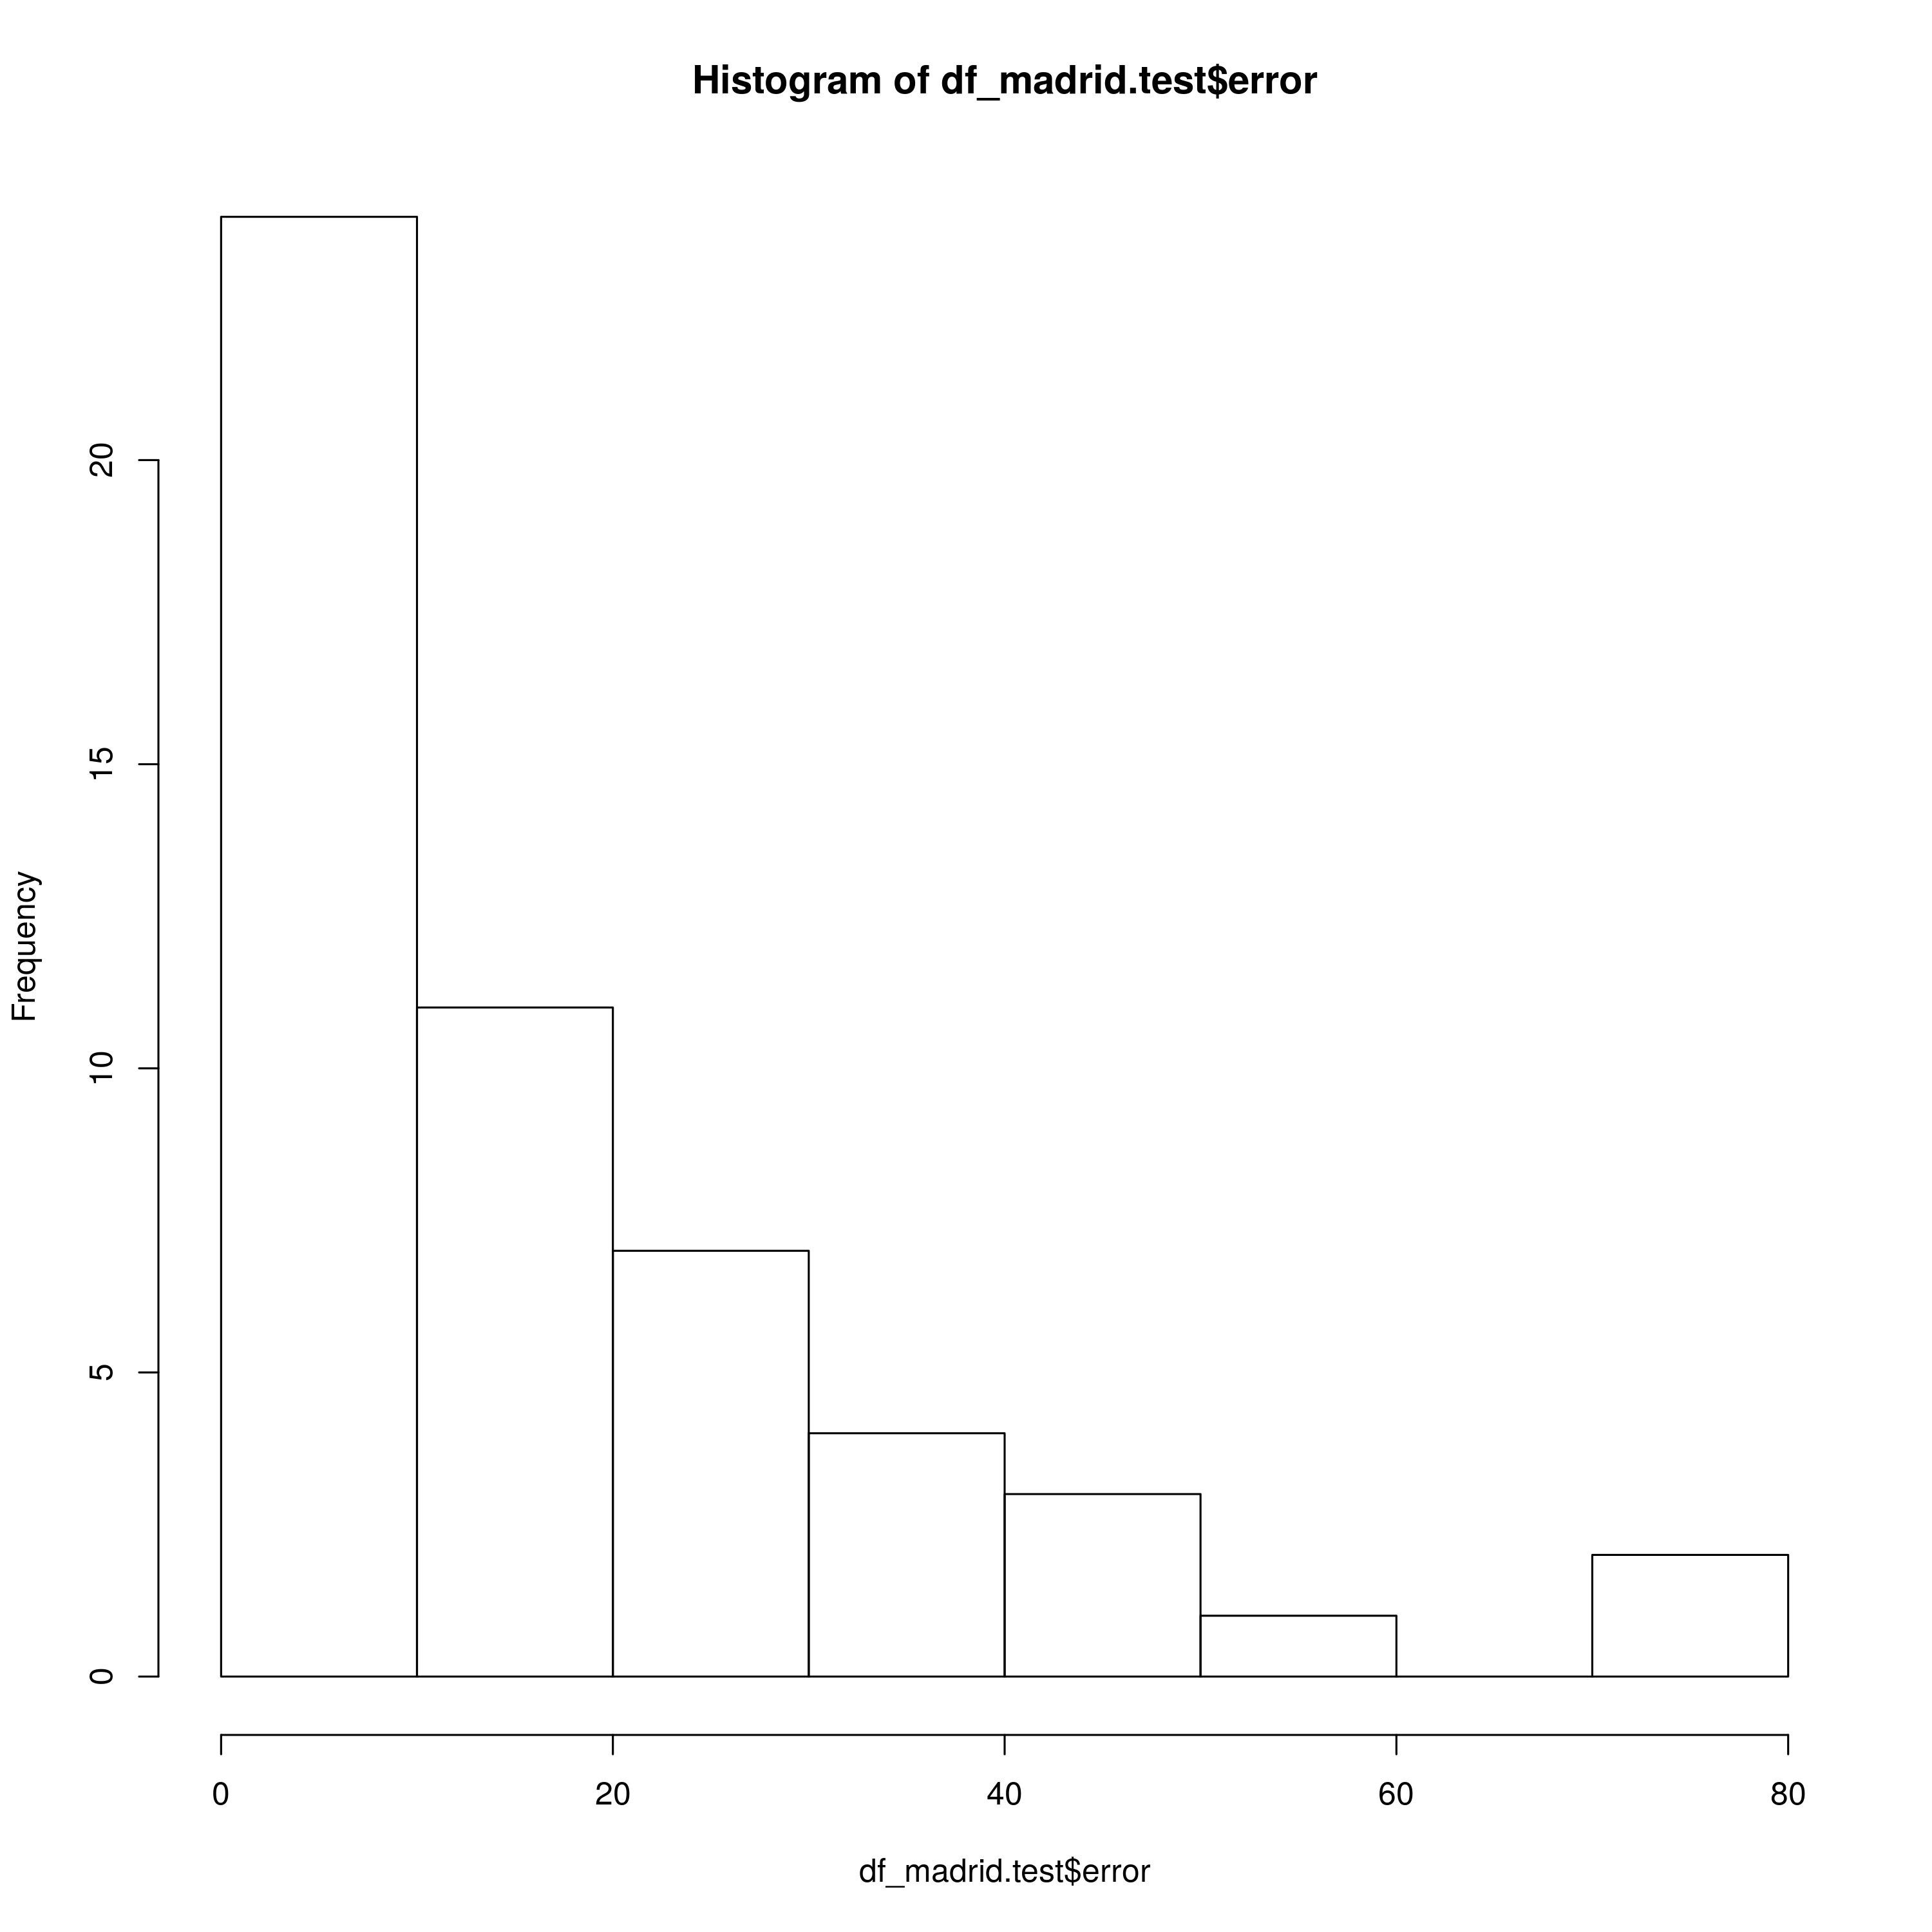

In [105]:
hist(df_madrid.test$error)

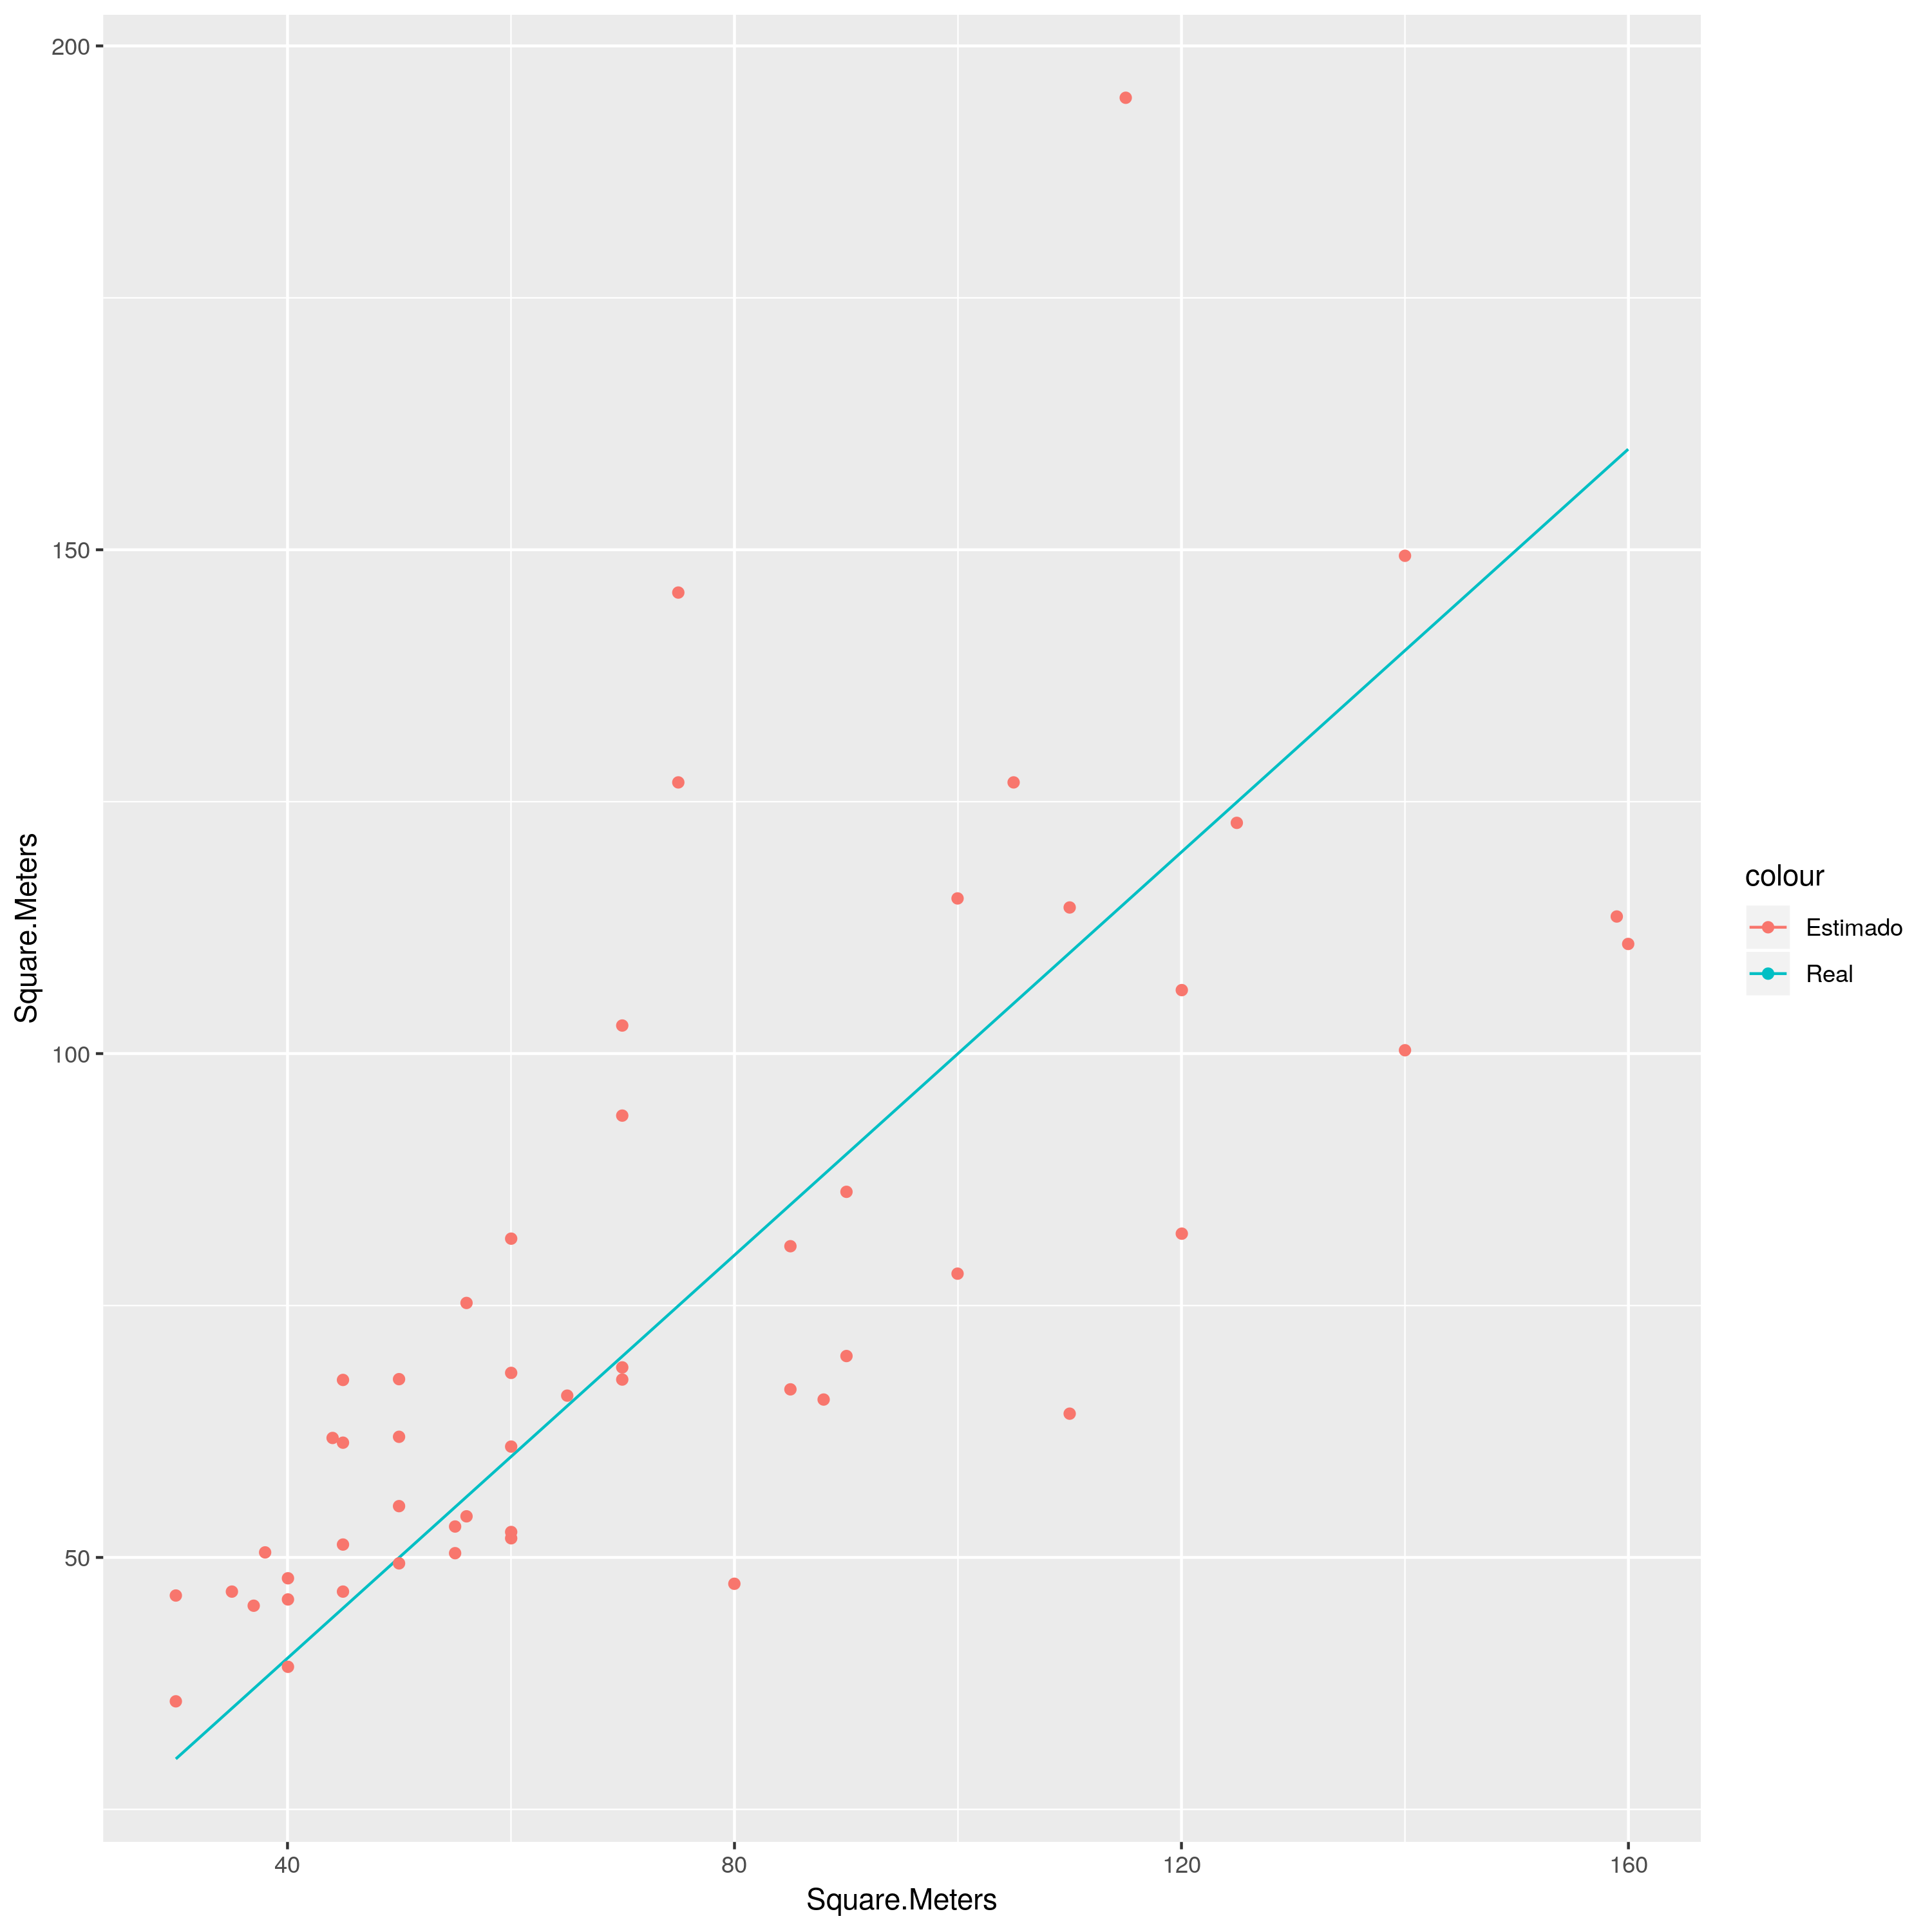

In [106]:
ggplot(df_madrid.test,aes(x=Square.Meters))+
    geom_line(aes(y=Square.Meters,color="Real"))+
    geom_point(aes(y=Estimated.SqMet,color="Estimado"))

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?